In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
ABC_ab = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
ABC_ab = preprocess_seqs(ABC_ab, "Y").sort_values(by="Protein")

data_ab = ABC_ab.select_dtypes(include=['float64']).T
info_ab = ABC_ab.select_dtypes(include=['object'])

treatments_ab = ["PC9", "Knock-Out", "Kin. Dead", "Knock-In", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
data_ab.index = treatments_ab

/home/marcc/resistance-MS/msresist/pre_processing.py:176: PerformanceWarning:

indexing past lexsort depth may impact performance.



In [4]:
ABC_ab

,Protein,Sequence,UniprotAcc,Abbv,Position,BioReps,r2_Std,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
0,26S proteasome regulatory subunit 4,DKKKKyEPPVP,P62191,PSMC1,Y25-p,1,N/A,-0.108045,-0.476332,-0.321637,-0.239781,0.126419,0.274226,0.243800,0.210842,0.326859,-0.036352
1,40S ribosomal protein S10,NRIAIyELLFK,P46783,RPS10,Y12-p,1,N/A,-0.169514,0.097204,-1.712342,0.173058,0.152218,-0.295116,0.846713,1.092283,-0.347285,0.162782
2,40S ribosomal protein SA,LTEASyVNLPT,P08865,RPSA,Y139-p,1,N/A,-0.905683,-0.264555,0.166887,0.990224,-0.256346,0.239761,-0.126352,0.681401,-0.332600,-0.192736
3,ARF GTPase-activating protein GIT1,DDQHDyDSVAS,Q9Y2X7,GIT1,Y383-p,1,N/A,0.670858,0.718143,0.225202,-0.528652,-0.461699,-0.161058,0.103659,-0.139631,-0.028111,-0.398711
4,ATPase WRNIP1,AGEEHyNCISA,Q96S55,WRNIP1,Y500-p,1,N/A,0.242877,0.226631,-0.140038,-0.402742,-0.033013,0.011860,0.085925,0.126432,-0.122947,0.005017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,Uridine 5'-monophosphate synthase,LSSPIyIDLRG,P11172,UMPS,Y37-p,1,N/A,-0.298600,-0.065573,-0.156597,0.019284,0.127287,-0.283888,0.528331,0.042304,0.150620,-0.063168
335,Vigilin,INRMDyVEINI,Q00341,HDLBP,Y437-p,1,N/A,-0.263325,-0.061066,0.226309,0.144577,-0.166762,-0.106788,0.162886,-0.096486,0.160574,0.000081
336,Vinculin,FLDSGyRILGA,P18206,VCL,Y822-p,3,0.25,-0.058125,-0.354182,-0.021402,-0.067675,0.268052,-0.249421,0.026603,0.151849,0.202528,0.101774
337,Vinculin,GNQAAyEHFET,P18206,VCL,Y692-p,3,0.3,-0.011366,-0.298127,-0.159582,-0.227588,0.064568,-0.240977,0.138258,0.164782,0.333162,0.236871


### Phenotypes

#### Cell Viability of AXL mutant Cell Lines

In [5]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR1.csv").iloc[:, 1:]
cv1_ab = cv1.loc[:, cv1.columns.str.contains('-A/E')]
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR2.csv').iloc[:, 1:]
cv2_ab = cv2.loc[:, cv2.columns.str.contains('-A/E')]
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR3.csv').iloc[:, 1:]
cv3_ab = cv3.loc[:, cv2.columns.str.contains('-A/E')]

for ii in range(0, cv2_ab.columns.size):
    cv1_ab.iloc[:, ii] /= cv1_ab.iloc[0, ii]
    cv2_ab.iloc[:, ii] /= cv2_ab.iloc[0, ii]
    cv3_ab.iloc[:, ii] /= cv3_ab.iloc[0, ii]

cv = pd.concat([cv1_ab, cv2_ab, cv3_ab], axis=0)
cv.insert(0, "Elapsed",  cv1.iloc[:, 0])
cv =  MergeDfbyMean(cv, cv1_ab.columns, "Elapsed").reset_index()
CV_ab = cv[cv["Elapsed"] == 120].iloc[0, 1:]
CV_ab = CV_ab[["PC9-A/E", "AXL KO-A/E", "Kdead-A/E", "Kin-A/E", "M4-A/E", "M5-A/E", "M7-A/E", "M10-A/E", "M11-A/E", "M15-A/E"]]

CV_ab

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1046: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



PC9-A/E       10.661811
AXL KO-A/E     2.814789
Kdead-A/E      4.405414
Kin-A/E        8.185261
M4-A/E         6.530231
M5-A/E         6.613370
M7-A/E         9.819472
M10-A/E        9.154419
M11-A/E        9.981410
M15-A/E        6.105206
Name: 40, dtype: float64

# Chained MS mixed clustering + PLSR analysis

### + Erlotinib + AF154

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:182: BiopythonWarning:

Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:182: BiopythonWarning:

Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:182: BiopythonWarning:

Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want 

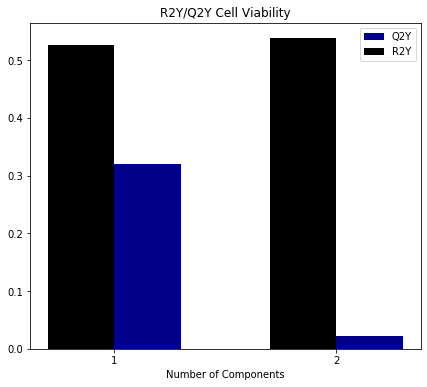

In [6]:
distance_method = "PAM250"
ncl = 2
GMMweight = 1

MSC = MassSpecClustering(info_ab, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data_ab, CV_ab)
centers_ab = MSC.transform(data_ab)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, centers_ab, CV_ab)

In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data_ab, info_ab, CV_ab, distance_method)

In [8]:
# CVresults_max, CVresults_min, best_params = MSclusPLSR_tuning(data_ab, info_ab, CV_ab, distance_method)

In [9]:
# ncl_GMMweight_ncomp = CVresults_min.sort_values(by="Ranking").iloc[:21, :]
# ncl_GMMweight_ncomp

In [10]:
# create_download_link(ncl_GMMweight_ncomp, "20200119-AxlMutants_GridSearch_PAM250_ErlAF154")

In [11]:
# labels = []
# for ii in range(ncl_GMMweight_ncomp.shape[0]):
#     labels.append(str(ncl_GMMweight_ncomp.iloc[ii, 1]) + 
#                   "|" + str(ncl_GMMweight_ncomp.iloc[ii, 2]) + 
#                   "|" + str(ncl_GMMweight_ncomp.iloc[ii, 3]))

    
# fig, ax = plt.subplots(1,1,figsize=(25,10))

# width = 0.5
# ax.bar(np.arange(ncl_GMMweight_ncomp.shape[0]), np.abs(ncl_GMMweight_ncomp.iloc[:, 4]), width, edgecolor='black', color='g')
# ax.set_xticks(np.arange(ncl_GMMweight_ncomp.shape[0]))
# ax.set_xticklabels(labels, fontsize=12)
# ax.set_xlabel("#Clusters | #Components | GMM Weight", fontsize=16)
# ax.set_ylabel("Mean-Squared Error (MSE)", fontsize=16)
# ax.set_title("Top20 Hyperparameter Combinations", fontsize=20)

In [12]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info_ab, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data_ab, CV_ab)
centers_ab = mixedCl_plsr.named_steps.mixedCl.transform(data_ab)

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:182: BiopythonWarning:

Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:182: BiopythonWarning:

Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.

/usr/local/lib/python3.7/dist-packages/Bio/Seq.py:182: BiopythonWarning:

Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want 

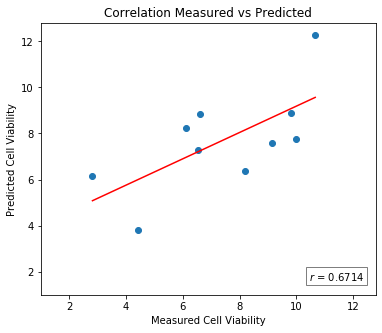

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data_ab, CV_ab)

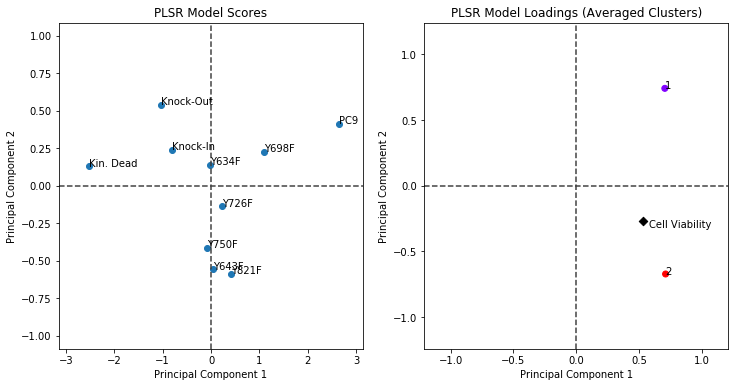

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers_ab, CV_ab, ncl, treatments_ab)

In [15]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC_ab.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

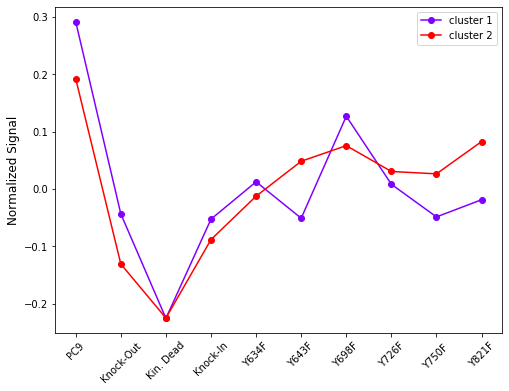

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# data = pd.concat([ABC_ab.iloc[:, :7], ABC_ab.iloc[:, 7:]], axis=1)
plotclusteraverages(ax, centers_ab.T, treatments_ab)